<a href="https://colab.research.google.com/github/hungryPanko/MultipleObjectDetection/blob/main/RetinaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Road Sign Detection

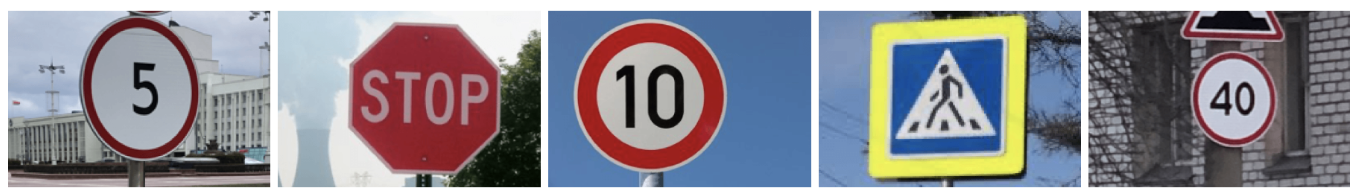

## [ Table of Contents ]

1. Exploring Dataset
2. Data Preprocessing
3. Simple CNN
4. RetinaNet
5. Faster R-CNN
6. References

## 1. Exploring Datasets
This dataset contains 877 images of 4 distinct classes for the objective of road sign detection and bounding box annotations. (source: [kaggle](https://www.kaggle.com/datasets/andrewmvd/road-sign-detection)) For the purpose of getting hands dirty on the multiple object detection problem in computer vision, we chose a smaller dataset, rather than a massive dataset that would take a lot of times to train.
The classes are:
- Traffic Light
- Stop
- Speed Limit
- Crosswalk


### 1.1 Understand the dataset

The xml files in the “annotations” folder contain the information for each image file. As an example, let’s take a look at the "road300.xml" file and corresponding image, "road300.jpg".

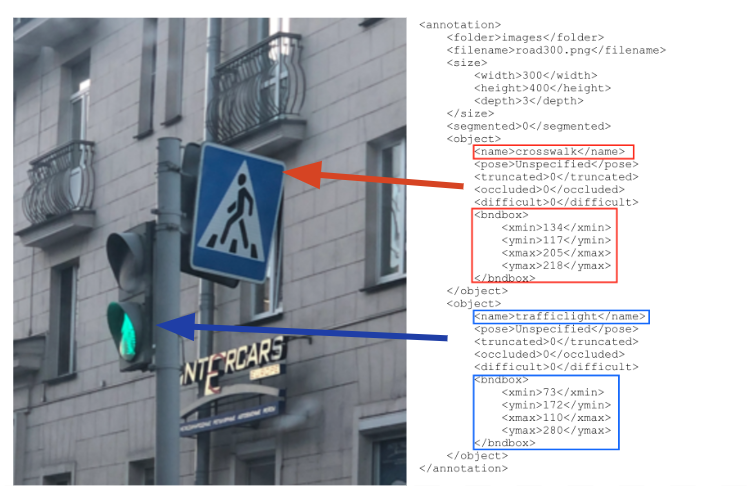

We can see that crosswalk and traffic light signes are in the image. Also, we can check image classification label on the xml file and their bounding boxes. 


### 1.2 Train/Valid data separation

We have total of 877 images. We will use 170 image as validation dataset.

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup

from PIL import Image
import cv2
import numpy as np
import time
import shutil
from tqdm import tqdm
import random


import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import albumentations as A
from albumentations.pytorch import ToTensorV2

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/SignalDetection2
torch.cuda.is_available()  # Go to Menu > Runtime > Change runtime to GPU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/SignalDetection2


True

In [2]:
img_list = sorted(glob.glob('./input/images/*'))
annot_list = sorted(glob.glob('./input/annotations/*'))

In [3]:
# Seperate Data
!mkdir test_images
!mkdir test_annotations

if (len(os.listdir('./input/images')) == len(os.listdir('./input/annotations')) == 877):
    #total of 877 images, We use 170 image as validation 
    random.seed(1234)
    idx = random.sample(range(877), 170) #707+170=877
    for img in np.array(sorted(os.listdir('./input/images')))[idx]:
        shutil.move('./input/images/'+img, './test_images/'+img)
    for annot in np.array(sorted(os.listdir('./input/annotations')))[idx]:
        shutil.move('./input/annotations/'+annot, './test_annotations/'+annot)
else: 
    print("Training/Valid data Seperation")

print("# of training image set: ", len(os.listdir('./input/annotations')))
print("# of training annotation set: ", len(os.listdir('./input/images')))
print("# of validation image set: ", len(os.listdir('./test_annotations')))
print("# of validation annotation set: ", len(os.listdir('./test_images')))

mkdir: cannot create directory ‘test_images’: File exists
mkdir: cannot create directory ‘test_annotations’: File exists
Training/Valid data Seperation
# of training image set:  707
# of training annotation set:  707
# of validation image set:  170
# of validation annotation set:  170


### 1.3 Labelling

For the training in the neural net, we would like to change the labeling from words to digits. 
For example, 
- speedlimit --> 0
- stop --> 1
- crosswalk --> 2
- trafficlight --> 3

In [4]:
# Help function for the labeling
def generate_label(obj, label_adjust=None):
    label_adjust = 1 if label_adjust else 0  # label: RetinaNet[0~N], Fast CNN[1~N] 
    if obj.find('name').text == "speedlimit":
        return 0 + label_adjust
    elif obj.find('name').text == "stop":
        return 1 + label_adjust
    elif obj.find('name').text == "crosswalk":
        return 2 + label_adjust
    elif obj.find('name').text == "trafficlight":
        return 3 + label_adjust

def generate_box(obj):
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def generate_target(file, model=None): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")
        num_objs = len(objects)
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i,label_adjust=model))
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        return target

### 1.4 Helper functions
We have created some helpful functions to draw the bounding box on the image. Each class has their own color of bounding box. 

In [5]:
# Helper function to draw the bounding box.
def plot_image(img_path, annotation):
    img = mpimg.imread(img_path)
    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='r',facecolor='none')
        elif annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='g',facecolor='none')
        elif annotation['labels'][idx] == 2 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='b',facecolor='none')
        elif annotation['labels'][idx] == 3 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='yellow',facecolor='none')
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

def plot_image_from_output(img, annotation):
    img = img.permute(1,2,0)
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]
        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='r',facecolor='none')
        elif annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='g',facecolor='none')
        elif annotation['labels'][idx] == 2 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='b',facecolor='none')
        elif annotation['labels'][idx] == 3 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='yellow',facecolor='none')
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='orange',facecolor='none')
        ax.add_patch(rect)
    plt.show()

Let's take a look how bounding boxes are displayed. 

As we can see, we have multiple road signs to detect in one image for some cases. 

167 ./input/annotations/road300.xml


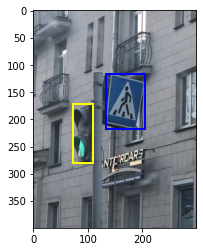

In [6]:
n = img_list.index('./input/images/road300.png')
print(n, annot_list[n])
bbox = generate_target(annot_list[n])
plot_image(img_list[n], bbox)

259 ./input/annotations/road40.xml


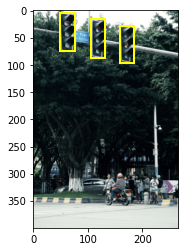

In [7]:
n = img_list.index('./input/images/road40.png')
print(n, annot_list[n])
bbox = generate_target(annot_list[n])
plot_image(img_list[n], bbox)

## 2. Data Preprocessing
What is image augmentation and how it can improve the performance of deep neural networks?
Deep neural networks require a lot of training data to obtain good results and prevent overfitting. However, it often very difficult to get enough training samples. Image augmentation is a process of creating new training examples from the existing ones. To make a new sample, you slightly change the original image. For instance, you could make a new image a little brighter; you could cut a piece from the original image; you could make a new image by mirroring the original one, etc. 
Augmentations help to fight overfitting and improve the performance of deep neural networks for computer vision tasks. 

### 2.1 Problems of Data Augmentation
Image augmenation for mutiple object detection problem needs quite different approach from image classification problem. The RandomHorizontalFlip performs a horizontal inversion with a probability of p. 

 


In [8]:
torchvision_transform = transforms.Compose([
    transforms.Resize((300, 300)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(p = 1),
    transforms.ToTensor(),
])

class TorchvisionMaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("./test_annotations/", file_label)
        else:
            label_path = os.path.join("./input/annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)
        
        if self.transform:
            img = self.transform(img)

        return img, target

Before applying transforms


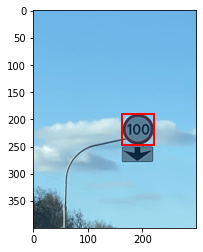

In [9]:
only_totensor = transforms.Compose([transforms.ToTensor()])
torchvision_dataset_no_transform = TorchvisionMaskDataset(
    path = './input/images/',
    transform = only_totensor
)

img, annot = torchvision_dataset_no_transform[261]
print('Before applying transforms')
plot_image_from_output(img, annot)

After applying transforms


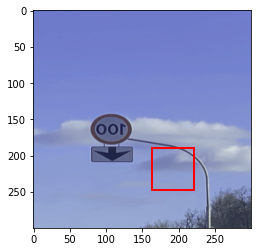

In [10]:
torchvision_dataset = TorchvisionMaskDataset(
    path = './input/images/',
    transform = torchvision_transform
)
img, annot = torchvision_dataset[261]
print('After applying transforms')
plot_image_from_output(img, annot)

After the transformation, flip and resize, the image changes the coordinates of pixels. If bounding box coordinates stay the same, that can be a problem as you see on the image. We need to change coordinates of bounding boxes as we transform the images. To handle this, we are using the Albumentation API. 

### 2.2 Bounding Box Augmentation 

The best part is that image augmentations libraries make it possible to add image augmentations to any computer vision pipeline with minimal effort. We are using the Albumentationslibraries for data augmentation.

In [11]:
# Data Augmentation
train_transform = A.Compose([ 
    A.Resize(300, 300),
    A.Affine(rotate=5, shear=10),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
)

valid_transform = A.Compose([ 
    A.Resize(300, 300),
    ToTensorV2()],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
)

In [12]:
# Data Loader
# The __init__ function is run once when instantiating the Dataset object.
# The __len__ function returns the number of samples in our dataset.
# The __getitem__ function loads and returns a sample from the dataset at the given index idx. 
class SignalDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("./test_annotations/", file_label)
        else:
            label_path = os.path.join("./input/annotations/", file_label)

        target = generate_target(label_path)
        
        if self.transform:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            transformed = self.transform(image=img, bboxes=target['boxes'], labels=target['labels'])
            img = transformed['image']/255  #RetinaNet input [0-1]
            target = {'boxes':torch.as_tensor(transformed['bboxes']), \
                      'labels':torch.as_tensor(transformed['labels'])}  
        else:
            img = Image.open(img_path).convert("RGB")
            to_tensor = torchvision.transforms.ToTensor()    
            img = to_tensor(img)

        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

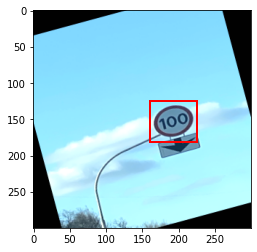

In [13]:
# Test ouput
bbox_transform_dataset = SignalDataset(
    path = './input/images/',
    transform = train_transform
)
img, annot = bbox_transform_dataset[261]
plot_image_from_output(img, annot)

We can see that the problem of bounding box coordination after the transformation is solved! 

### 2.3 Data Augmentation for Training / Validataion set

For the training image, we applied transformation such as resize, affine transformation, random horizontal filp, and and brightness contrast. For the validation, we only applied the resize. 

The TorchvisionDataset class loads images through the __getitem__ method. It loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s location on disk, converts that to a tensor using __read_image__, retrieves the corresponding label from the xml data in target, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.

Augmentation is performed according to the rule stored in the transform parameter.

In [14]:
dataset = SignalDataset('./input/images/', transform=train_transform)
test_dataset = SignalDataset('./test_images/', transform=valid_transform)

#Batch Size - the number of data samples propagated through the network before the parameters are updated
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

Let's check out the output format after iteration on TorchvisionDataset. It's helpful to build the CNN. 

Image pixel value is between 0-1, and annotaion is dictionary format. 'boxes' contains the bounding box coordination and 'labels' contains each class. 

In [15]:
# Check out for the output for the batch iteration. 
img, target = next(iter(data_loader))
print("Image size: ",img[0].shape)
print("Annotation(Mini Batch): ",target)
print("Annotation(Single): ",target[0])
print("Bounding Box: ", target[0]['boxes'])
print("Labe: ",target[0]['labels'])
print("Image pixel: ",img[0][0:10])

Image size:  torch.Size([3, 300, 300])
Annotation(Mini Batch):  ({'boxes': tensor([[110.1124,  46.5000, 233.7079, 174.0000]], dtype=torch.float64), 'labels': tensor([3])}, {'boxes': tensor([[106.5000,  66.7845, 184.5000, 297.8799]], dtype=torch.float64), 'labels': tensor([3])}, {'boxes': tensor([[117.0000,   3.3708, 220.5000, 295.5056]], dtype=torch.float64), 'labels': tensor([3])}, {'boxes': tensor([[ 26.2500,   3.8961, 272.2500, 254.0260]], dtype=torch.float64), 'labels': tensor([0])}, {'boxes': tensor([[146.2500,  10.5000, 294.0000, 291.0000]], dtype=torch.float64), 'labels': tensor([0])}, {'boxes': tensor([[ 39.7919,  10.5885, 249.5420, 287.9354]], dtype=torch.float64), 'labels': tensor([0])}, {'boxes': tensor([[ 27.0000, 109.5000, 281.0000, 282.7500]], dtype=torch.float64), 'labels': tensor([0])}, {'boxes': tensor([[116.8539, 112.5000, 186.5169, 169.5000]], dtype=torch.float64), 'labels': tensor([0])}, {'boxes': tensor([[ 79.6254,  14.4185, 242.9758, 189.6785]], dtype=torch.float6

### 2.4 Counding objects per class
Multiple object detection problem requires to check how many objects for each class exist in the dataset. Let's see how many objects in each classes are in training/ validation set. 

In [16]:
from collections import Counter
from tqdm import tqdm

def get_num_objects_per_class(dataset):
    labels = []
    for img, annot in tqdm(dataset, position = 0, leave = True):
        labels += [int(i) for i in annot['labels']]
    return Counter(labels)

train_objects = get_num_objects_per_class(dataset)
test_objects = get_num_objects_per_class(test_dataset)
print('\n Object in training data', train_objects)
print('\n Object in test data', test_objects)

100%|██████████| 170/170 [00:02<00:00, 76.53it/s]


 Object in training data Counter({0: 633, 2: 146, 3: 141, 1: 75})

 Object in test data Counter({0: 149, 2: 54, 3: 28, 1: 16})


It consists of 877 images. Most images have a single objects to detect. It’s a pretty imbalanced dataset, with most images belonging to the speed limit class(0), but since we’re more focused on the bounding box prediction, we can ignore the imbalance.

# 4. Transfer Learning: RetinaNet

Quoting these [notes,](https://cs231n.github.io/transfer-learning/)

" In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest. " 

[ Fine-tuning the RetinaNet ]

- Backbone: Pretrained on Coco
- Replace classifier and regression to our dataset
- Retrain on top of the RetinaNet
- Fine-tune the weights by continuing the backpropagation
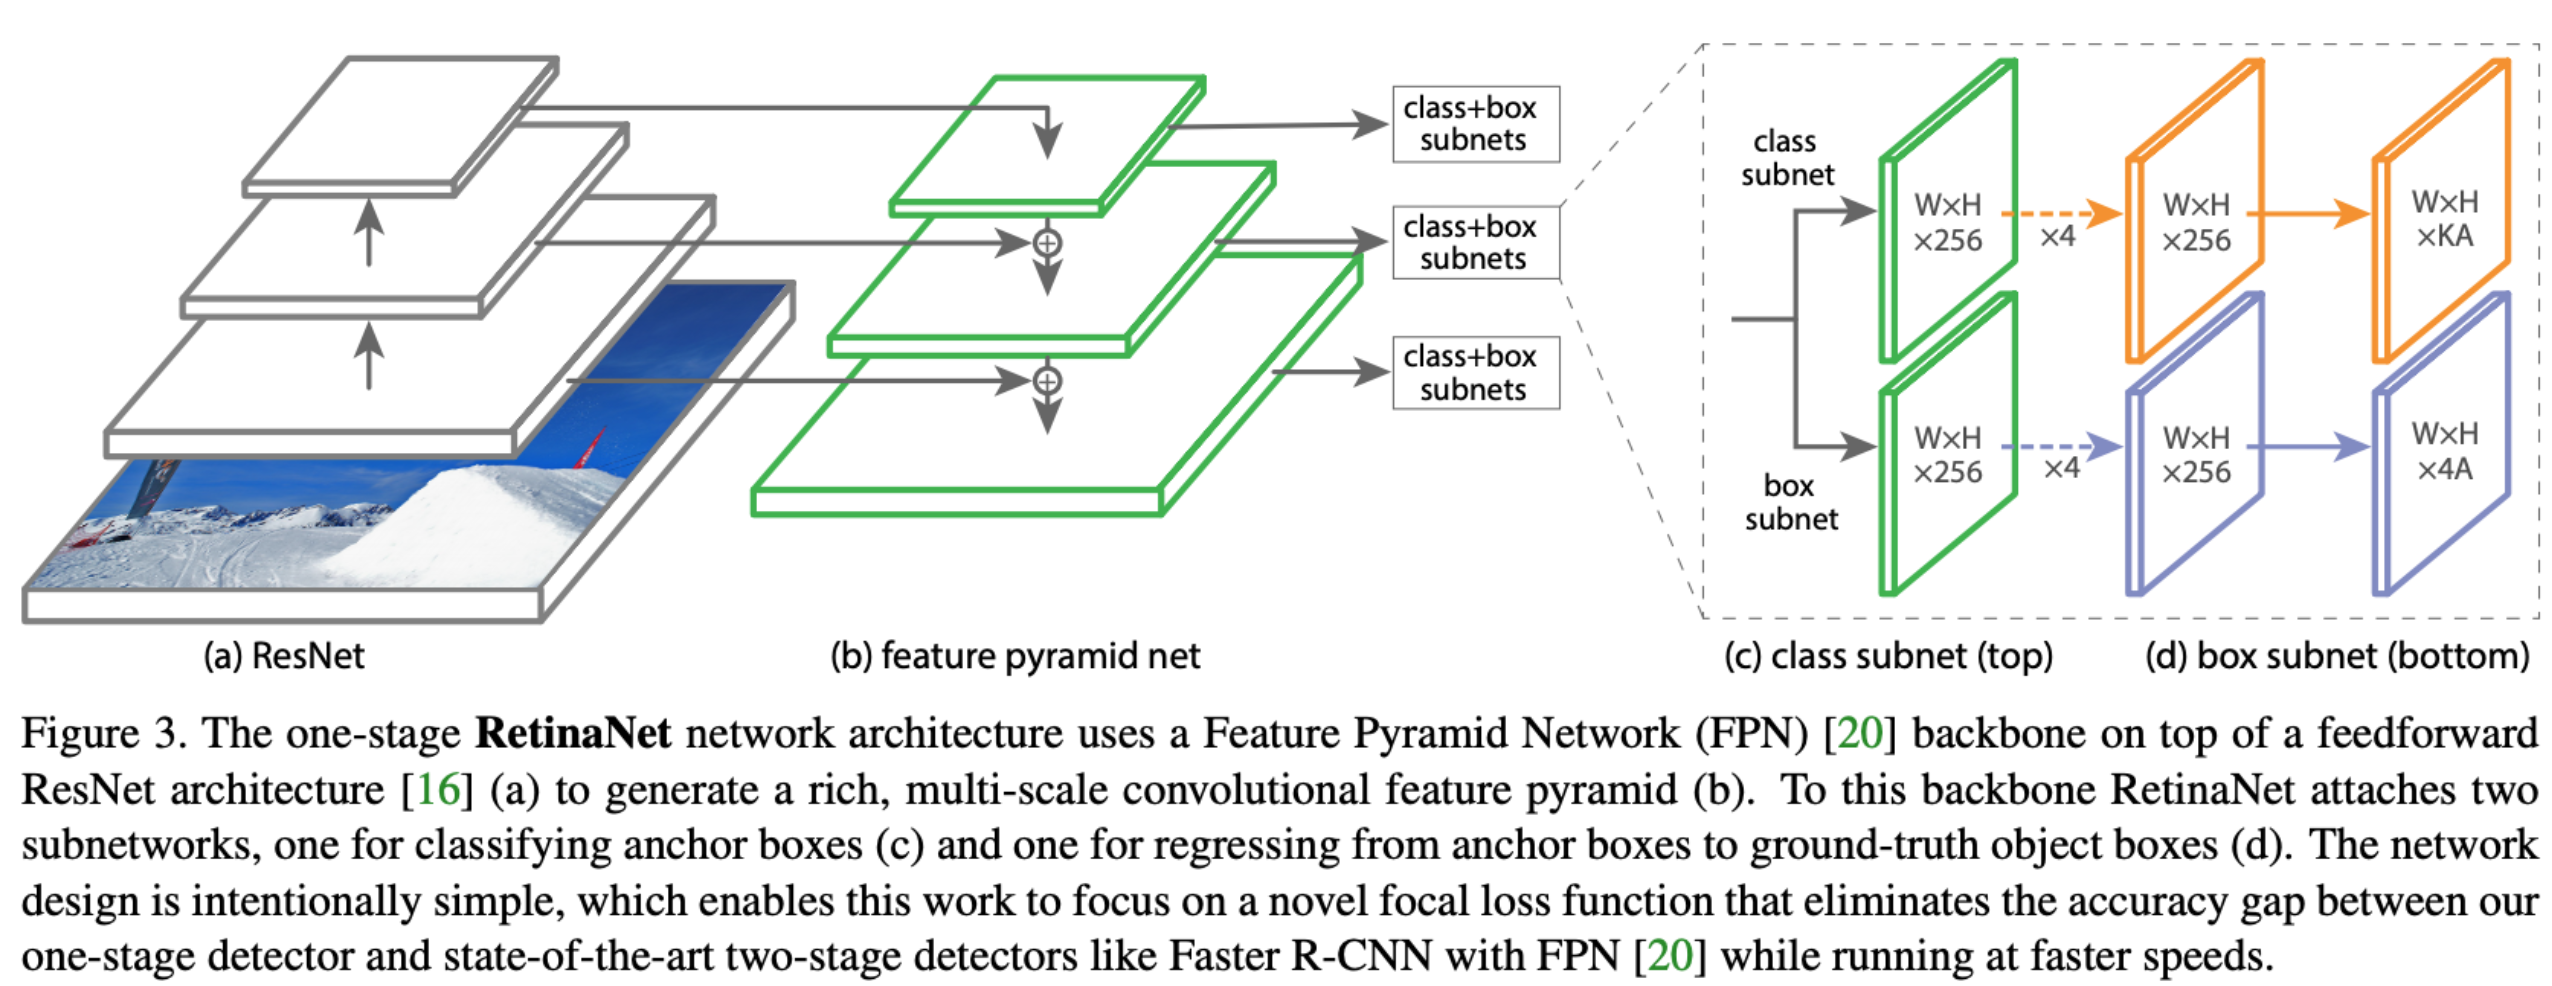

### 4.1 Load Retina Net 

Torchvision provides deep learning models for solving computer vision tasks. We will use the torchvision.models module to import RetinaNet. Since there are 4 classes in the Road Sign Detection dataset, the num_classes parameter is defined as 4. 

In order to perform transfer learning, the backbone structure comes with pre-trained weights. We want to start from a model pre-trained on COCO, which is famous for its object detection dataset, and then finetune it for our particular classes. 

In [17]:
# Number of classes = 4 (4 classes)
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes=4, pretrained=False, pretrained_backbone = True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to pass

If we already trained the model before and saved it, we will reuse it to save the time. If it is the first time to train, we will run the code to learn the weights and save the model. 

In [18]:
# Number of Epochs - the number times to iterate over the dataset
# About 4 min takes per epoch during training  on Colab GPU
num_epochs = 29 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
saved_model = None

try: 
    # If we have saved the training model, load it
    retina.load_state_dict(torch.load(f'retina_{num_epochs}.pt'))
    print("Loading saved model")
    saved_model = True
except:
    # For the first training
    print("Training for the first time!")
    saved_model = False

retina.to(device)

Training for the first time!


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

###4.2 Transfer Learning
After importing the model, we will use the code below to perform transfer learning.

Training a model is an iterative process; in each iteration the model makes a guess about the output, calculates the error in its guess (loss), collects the derivatives of the error with respect to its parameters, and optimizes these parameters using gradient descent.



#### hyperparameters
 
- Learning Rate(lr): How much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

- Momentum: Momentum is introduced to speed up the learning process, especially for the gradient with high curvature, small but consistent, which can accelerate the learning process. The main idea of momentum is to accumulate the moving average of previous gradients decaying exponentially.

- Weight Decay: The weight_decay parameter adds a L2 penalty to the cost which can effectively lead to to smaller model weights.


##### Optimizer
Optimization is the process of adjusting model parameters to reduce model error in each training step. Optimization algorithms define how this process is performed. All optimization logic is encapsulated in the optimizer object. Here, we use the SGD optimizer; additionally, there are many different optimizers available in PyTorch such as ADAM and RMSProp. 

We initialize the optimizer by registering the model’s parameters that need to be trained, and passing in the learning rate, momentum, and wieght_decay hyperparameters.



In [19]:
if not saved_model:
    # hyperparameters
    params = [p for p in retina.parameters() if p.requires_grad] # select parameters that require gradient calculation
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005) # construct an optimizer
    len_dataloader = len(data_loader)

#### Optimization Loop

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an epoch.
- The Train Loop - iterate over the training dataset and try to converge to optimal parameters.



#### Loss Function
When presented with some training data, our untrained network is likely not to give the correct answer. Loss function measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

In [20]:
if not saved_model:
    # Training a model is an iterative process
    for epoch in range(num_epochs):
        start = time.time()
        retina.train() # Training

        i = 0    
        epoch_loss = 0
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = retina(images, targets) # Compute loss
            # Loss function measures the degree of dissimilarity of obtained result to the target value
            losses = sum(loss for loss in loss_dict.values()) 
            i += 1

            # Backpropagation
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            # Sum loss for each epoch
            epoch_loss += losses 
        print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

epoch : 1, Loss : 76.74559498004042, time : 106.46723413467407
epoch : 2, Loss : 75.85184099127564, time : 103.59798884391785
epoch : 3, Loss : 72.37947914672438, time : 103.40464091300964
epoch : 4, Loss : 72.1808343901771, time : 102.82599973678589
epoch : 5, Loss : 68.14326810749797, time : 103.04368543624878
epoch : 6, Loss : 67.50114628781311, time : 102.49140977859497
epoch : 7, Loss : 62.594183221273155, time : 102.49405264854431
epoch : 8, Loss : 50.78975480005989, time : 102.3589825630188
epoch : 9, Loss : 56.697089595271585, time : 101.81583046913147
epoch : 10, Loss : 38.815816437761335, time : 102.08831214904785
epoch : 11, Loss : 34.19554924488327, time : 102.35137009620667
epoch : 12, Loss : 29.072249067212923, time : 102.21073389053345
epoch : 13, Loss : 29.01360561839612, time : 102.07023668289185
epoch : 14, Loss : 27.01599307609461, time : 101.98805665969849
epoch : 15, Loss : 24.826299380610358, time : 102.2506697177887
epoch : 16, Loss : 29.027230432050246, time : 1

#### Saving and Loading Model Weights
PyTorch models store the learned parameters in an internal state dictionary, called state_dict. These can be persisted via the torch.
To reuse the model, we will save the learned weights. The torch.save function is used to save the model weights at the designated location.

In [21]:
# Save the trained model
if not saved_model:
    torch.save(retina.state_dict(),f'retina_{num_epochs}.pt')

### 4.3 Prediction
The training process has been completed. Now we will check the prediction. We will load the data using test_data_loader and input them into the model. In the model prediction phase, we use the threshold parameter to select bounding boxes with a certain level of confidence or higher. Then, we will inferences on all the data in test_data_loader using the loop.

In [22]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []
        
        # the threshold parameter: select bounding boxes with a certain level of confidence or higher.
        for idx, score in enumerate(preds[id]['scores']) : # confidence score
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

- preds_adj_all: predicted results
- annot_all: actual labels for all test data

In [23]:
# Make inferences on all the data in test_data_loader.
labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(retina, im, 0.5) # Use threshold = 0.5 for rule of thumb
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 85/85 [00:15<00:00,  5.34it/s]


In [24]:
# Print testing stats
total_obj = 0
correct_detect_obj = 0
invalid_detect_obj = 0
for idx, samp_ann in enumerate(annot_all):
    samp_pred = preds_adj_all[idx]
    ann_labels = [o['labels'] for o in samp_ann] # Array of 1x1 tensor
    pred_labels = [o['labels'] for o in samp_pred]
    # Flatten
    tmp = []
    for p in pred_labels:
        for pp in p: tmp.append(pp)
    pred_labels = tmp
    tmp = []
    for p in ann_labels:
        for pp in p: tmp.append(pp)
    ann_labels = tmp
    # print(f'actual = {ann_labels}, predicted = {pred_labels}')
    for o in ann_labels:
        total_obj+=1
        if o in pred_labels:
            correct_detect_obj+=1
            pred_labels.remove(o)
    invalid_detect_obj+=len(pred_labels)

print(f'Validation accuracy: {correct_detect_obj/total_obj*100:0.1f}%')
print(f'total objects: {total_obj}, correctly identified objects: \
        {correct_detect_obj}, falsely detected objects = {invalid_detect_obj}')

Validation accuracy: 71.7%
total objects: 247, correctly identified objects:         177, falsely detected objects = 62


Next, we will visualize the predicted bounding boxes along with the actual ones. 

In [25]:
def plot_image_from_output(img, annotation):
    img = img.cpu().permute(1,2,0)
    rects = []
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]
        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=3,edgecolor='r',facecolor='none')
        elif annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=3,edgecolor='g',facecolor='none')
        elif annotation['labels'][idx] == 2 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=3,edgecolor='b',facecolor='none')
        elif annotation['labels'][idx] == 3 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=3,edgecolor='yellow',facecolor='none')
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=3,edgecolor='orange',facecolor='none')
        rects.append(rect)
        
    return img, rects

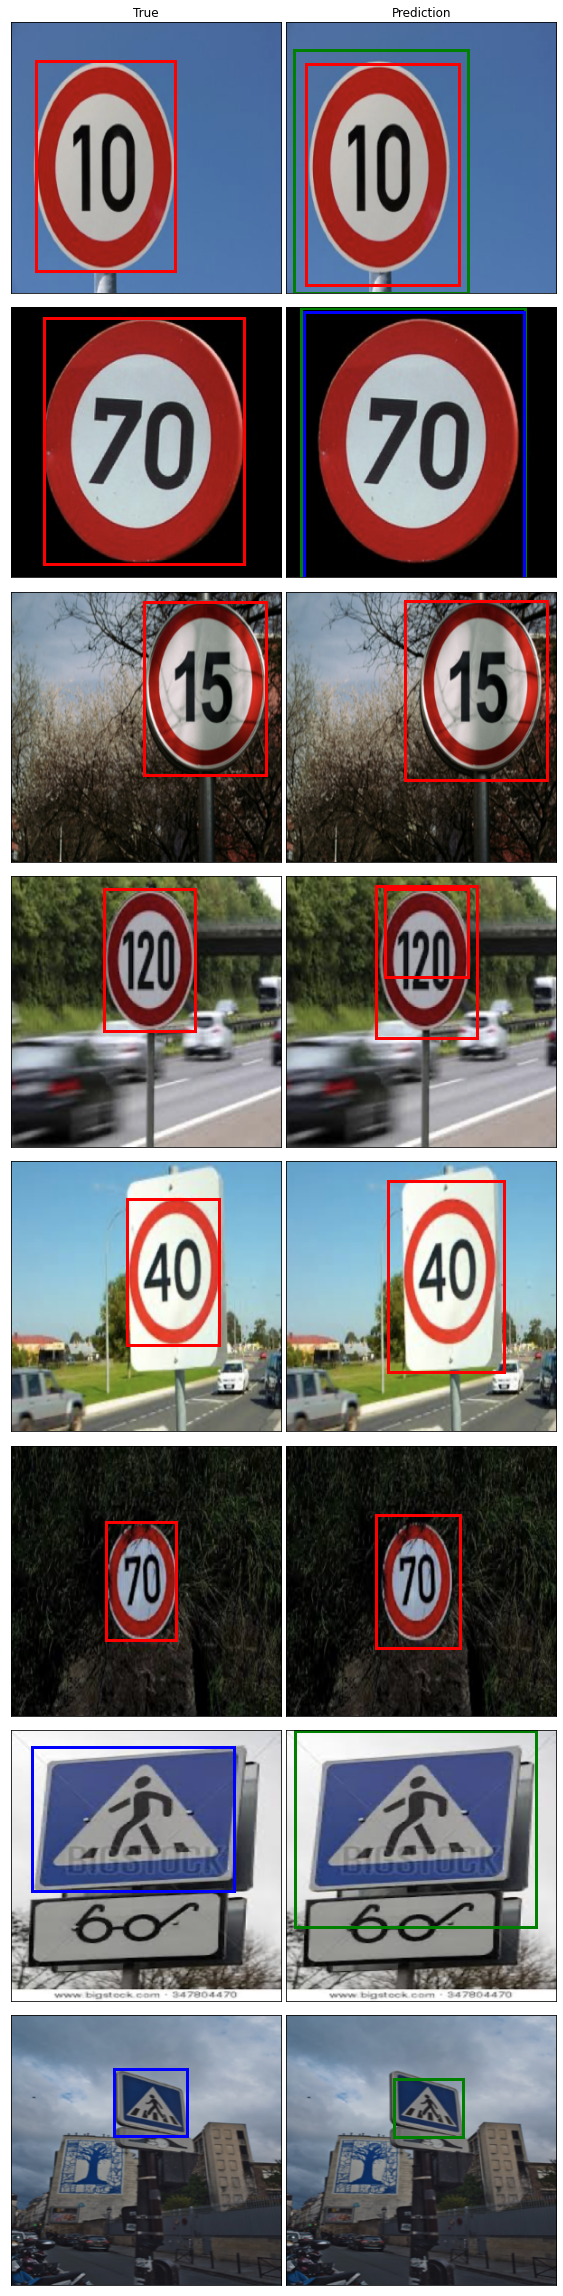

In [26]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in test_data_loader:
    pos = batch_i * 4 + 1
    for sample_i in range(len(im)) :
        img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
        axes[(pos)//2, 1-((pos)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos)%2)].add_patch(rect)
        
        img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
        axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)
        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# remove xtick, ytick
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Prediction']
for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()

However, for the images that have more than one labels have a low accuracy. This is because our training data is skewed. Majory of the images have only one lable in a single image. It is hard to learn about the multiple object detection. 

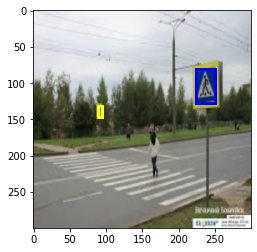

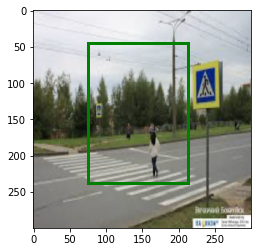

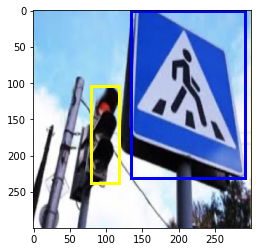

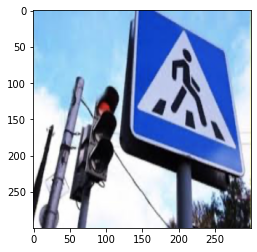

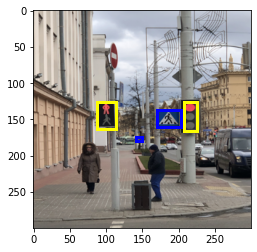

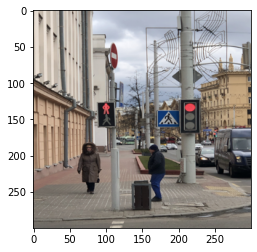

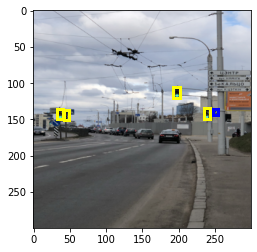

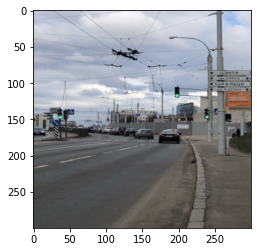

In [27]:
def plot_image_from_output(img, annotation):
    img = img.permute(1,2,0)
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]
        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=3,edgecolor='r',facecolor='none')
        elif annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=3,edgecolor='g',facecolor='none')
        elif annotation['labels'][idx] == 2 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=3,edgecolor='b',facecolor='none')
        elif annotation['labels'][idx] == 3 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=3,edgecolor='yellow',facecolor='none')
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=3,edgecolor='orange',facecolor='none')
        ax.add_patch(rect)
    plt.show()

num_drawing = 0 
for im, annot in test_data_loader:
    for sample_i in range(len(im)) :
        if len(annot[sample_i]["boxes"]) >= 2: 
            plot_image_from_output(im[sample_i], annot[sample_i])
            plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
            num_drawing += 1 
            
    if num_drawing == 4:
        break